# ROC

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from collections import defaultdict

mpl.rcParams['figure.figsize'] = (6,6)
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams["image.origin"] = 'lower'

In [28]:
config = {
    "base_dir":        "/eos/user/d/dvalsecc/www/VBSPlots/DNN_archive/FullRun2_v7/",
    "plot_config":     "FullRun2_v7",
    "cut":             "boost_sig",
    "model_version":   "v3_d",
}

In [29]:
import os

config_base_dir = os.path.join(config["base_dir"], config["plot_config"])

# create the model directory
model_dir   = os.path.join(config_base_dir, config["cut"] , "models",  config["model_version"])
os.makedirs(model_dir, exist_ok=True)

import yaml
model_config_file = open(model_dir + "/model_config.yml", "r")
model_config = yaml.safe_load(model_config_file)

for key in ["samples_version", "cols"]:
    config[key] = model_config[key]

In [30]:
# load numpy
samples_dir = os.path.join(config_base_dir, config["cut"] , "samples", config["samples_version"])
import pickle
signal = pickle.load(open(os.path.join(samples_dir, "for_training/signal_balanced.pkl"),     "rb"))
bkg    = pickle.load(open(os.path.join(samples_dir, "for_training/background_balanced.pkl"), "rb"))

In [31]:
X_sig = signal[config["cols"]].values
X_bkg = bkg[config["cols"]].values
Y_sig = np.ones(len(X_sig))
Y_bkg = np.zeros(len(X_bkg))
W_sig = (signal["weight_norm"]).values
W_bkg = (bkg["weight_norm"]).values
Wnn_sig = (signal["weight"]).values
Wnn_bkg = (bkg["weight"]).values

X = np.vstack([X_sig, X_bkg])
Y = np.hstack([Y_sig, Y_bkg])
W = np.hstack([W_sig, W_bkg])
Wnn = np.hstack([Wnn_sig, Wnn_bkg])

from sklearn.preprocessing import StandardScaler
#scaler = pickle.load(open(f"{model_dir}/scaler_model.pkl", "rb"))
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [32]:
import tensorflow as tf

model = tf.keras.models.load_model(os.path.join(model_dir, "model.h5"))

model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 64)                896       
_________________________________________________________________
batch_normalization_4 (Batch (None, 64)                256       
_________________________________________________________________
activation_4 (Activation)    (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 32)                2080      
_________________________________________________________________
batch_normalization_5 (Batch (None, 32)                128       
_________________________________________________________________
activation_5 (Activation)    (None, 32)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 32)               

In [33]:
bkg["y"] = model.predict(scaler.transform(bkg[config["cols"]].values), batch_size=2048)
signal["y"] = model.predict(scaler.transform(signal[config["cols"]].values), batch_size=2048)

In [34]:
from sklearn.model_selection import train_test_split
bkg_train, bkg_test = train_test_split(bkg, train_size=0.70, random_state=42)
signal_train, signal_test = train_test_split(signal, train_size=0.70, random_state=42)

In [11]:
wjets = bkg[bkg["sample_name"] == "Wjets_HT"]
top = bkg[bkg["sample_name"] == "top"]
dy = bkg[bkg["sample_name"] == "DY"]

Without weights

In [13]:
!pip install --user mplhep

     |████████████████████████████████| 5.4MB 7.9MB/s eta 0:00:01


In [35]:
import mplhep as hep
hep.set_style(hep.style.CMS)
import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.ROOT)
# Overall - both left and right annotation


(exptext: Custom Text(0.0, 1, 'CMS'), expsuffix: Custom Text(0.0, 1.005, ''))


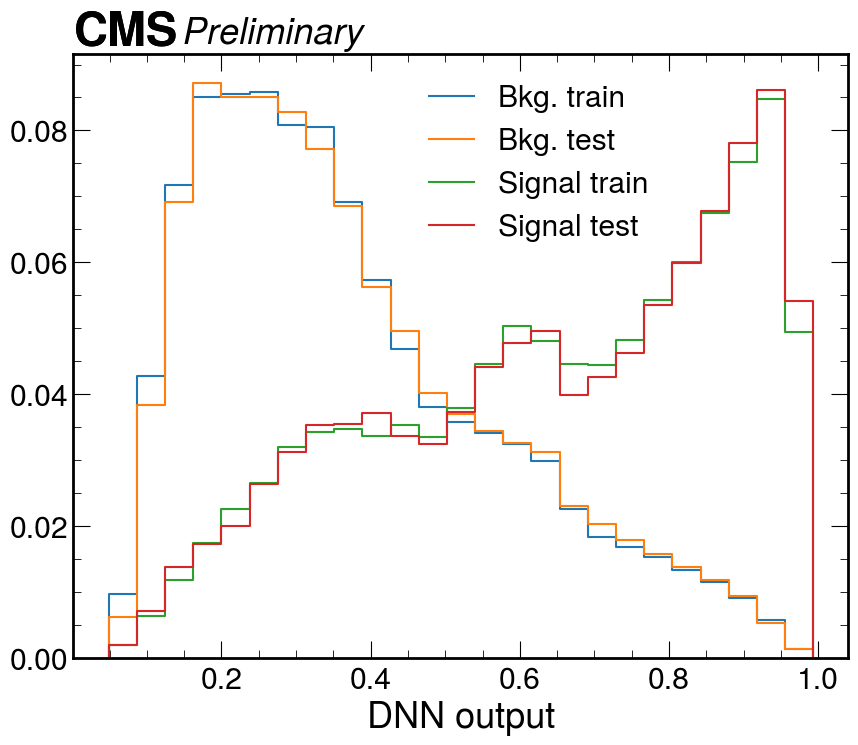

In [36]:
fig, ax1 = plt.subplots(figsize=(10,8), dpi=100)


h_bkg_tr, bins = np.histogram(bkg_train["y"], bins=25, weights=bkg_train.weight)
h_bkg_tr = h_bkg_tr/ np.sum(h_bkg_tr)

h_bkg_test, bins = np.histogram(bkg_test["y"], bins=25, weights=bkg_test.weight)
h_bkg_test = h_bkg_test/ np.sum(h_bkg_test)

h_sig_tr, bins = np.histogram(signal_train["y"], bins=25, weights=signal_train.weight)
h_sig_tr = h_sig_tr/ np.sum(h_sig_tr)

h_sig_test, bins = np.histogram(signal_test["y"], bins=25, weights=signal_test.weight)
h_sig_test = h_sig_test/ np.sum(h_sig_test)

a = hep.histplot(h_bkg_tr, bins, ax=ax1, label="Bkg. train")
b= hep.histplot(h_bkg_test, bins, ax=ax1,label="Bkg. test")
hep.histplot(h_sig_tr, bins, ax=ax1, label="Signal train")
hep.histplot(h_sig_test, bins, ax=ax1, label="Signal test")

plt.xlabel('DNN output')

plt.legend(loc='upper center', bbox_to_anchor=(0.6,1))
#hep.cms.label()
# Just experiment label and <text> such as 'Preliminary' or 'Simulation'
hep.cms.text("Preliminary ",loc=0)
print(hep.cms.text())
#plt.yscale("log")

plt.savefig(model_dir + "/train_test_distribution.png")

In [ ]:
fig, ax1 = plt.subplots(figsize=(10,8), dpi=100)


h_bkg_tr, bins = np.histogram(bkg_train["y"], bins=25, weights=bkg_train.weight)
h_bkg_tr = h_bkg_tr/ np.sum(h_bkg_tr)

h_bkg_test, bins = np.histogram(bkg_test["y"], bins=25, weights=bkg_test.weight)
h_bkg_test = h_bkg_test/ np.sum(h_bkg_test)

h_sig_tr, bins = np.histogram(signal_train["y"], bins=25, weights=signal_train.weight)
h_sig_tr = h_sig_tr/ np.sum(h_sig_tr)

h_sig_test, bins = np.histogram(signal_test["y"], bins=25, weights=signal_test.weight)
h_sig_test = h_sig_test/ np.sum(h_sig_test)

a = hep.histplot(h_bkg_tr, bins, ax=ax1, label="Bkg. train")
b= hep.histplot(h_bkg_test, bins, ax=ax1,label="Bkg. test")
hep.histplot(h_sig_tr, bins, ax=ax1, label="Signal train")
hep.histplot(h_sig_test, bins, ax=ax1, label="Signal test")

plt.xlabel('DNN output')

plt.legend(loc='upper center', bbox_to_anchor=(0.6,1))
#hep.cms.label()
# Just experiment label and <text> such as 'Preliminary' or 'Simulation'
hep.cms.text("Preliminary ",loc=0)
print(hep.cms.text())
#plt.yscale("log")

In [147]:
print(bkg_train.shape[0] + bkg_test.shape[0])
print(signal_train.shape[0] + signal_test.shape[0])

415960
50231


In [24]:
thr = np.linspace(0.6, 1.,50)

tot_bkg_train = np.sum(bkg_train.weight)
tot_bkg_test = np.sum(bkg_test.weight)
tot_sig_train = np.sum(signal_train.weight)
tot_sig_test = np.sum(signal_test.weight)

b_tr = [] 
b_test = [] 
s_tr = []
s_test = []

for x in thr:
    a = np.sum(bkg_train[bkg_train["y"]> x]["weight"])
    b_tr.append(a/tot_bkg_train)
    a = np.sum(bkg_test[bkg_test["y"]> x]["weight"])
    b_test.append(a/tot_bkg_test)
    a = np.sum(signal_train[signal_train["y"]> x]["weight"])
    s_tr.append(a/tot_sig_train)
    a = np.sum(signal_test[signal_test["y"]> x]["weight"])
    s_test.append(a/tot_sig_test)
    print(s_test[-1])
    
    

0.595950189642747
0.5859261241044615
0.5763144615545189
0.5662499705336866
0.5560335406811363
0.5464959127913432
0.5365491353676534
0.5271212791259882
0.5175521513842749
0.5087501016623052
0.4993503302267982
0.49003468192752214
0.480121140685528
0.47097720821914696
0.4611385639494907
0.4511764296162292
0.4412349954194834
0.43206961847960224
0.42203765102399954
0.4117654157949472
0.4002182014516151
0.3901071691062728
0.37983704893917153
0.36827920069850234
0.35760190591198643
0.3465307903460095
0.33536306005368643
0.32401574642818787
0.3124442448806247
0.3005602083146789
0.28842315153684306
0.276025371930187
0.2624384115062004
0.24811458589809646
0.23426489029584485
0.21937351709927627
0.2046123457358695
0.19004254215778035
0.17495535600999695
0.1596191884920203
0.14400259115599426
0.12630903275608774
0.10881581756051192
0.09034045004368602
0.07284210603165801
0.05404462256378031
0.03468628621418863
0.015998978391333393
0.0028461618257230896
0.0


0.061838796785599004


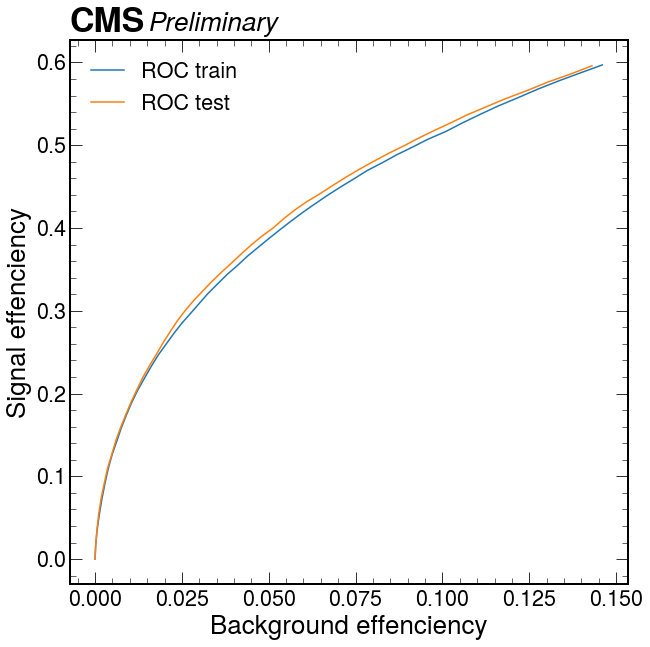

In [27]:
from sklearn.metrics import auc
plt.plot(b_tr,s_tr, label='ROC train')
plt.plot(b_test,s_test,  label='ROC test')
plt.xlabel("Background effenciency")
plt.ylabel("Signal effenciency")
hep.cms.text("Preliminary")
plt.legend()
print(auc(b_tr[:-3],s_tr[:-3]))
plt.savefig(model_dir + "/roc.png")

0.061610089553901966


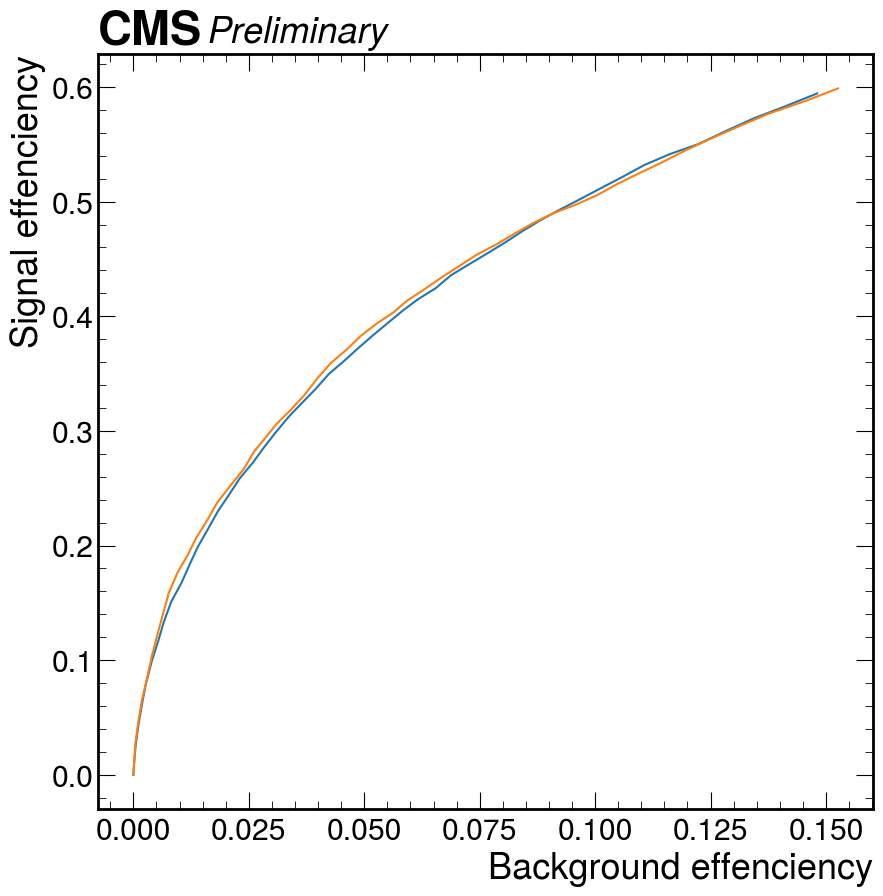

In [146]:
from sklearn.metrics import auc
plt.plot(b_tr,s_tr, label='ROC train')
plt.plot(b_test,s_test,  label='ROC test')
plt.xlabel("Background effenciency")
plt.ylabel("Signal effenciency")
hep.cms.text("Preliminary")
print(auc(b_tr[:-3],s_tr[:-3]))

0.8121926514931318


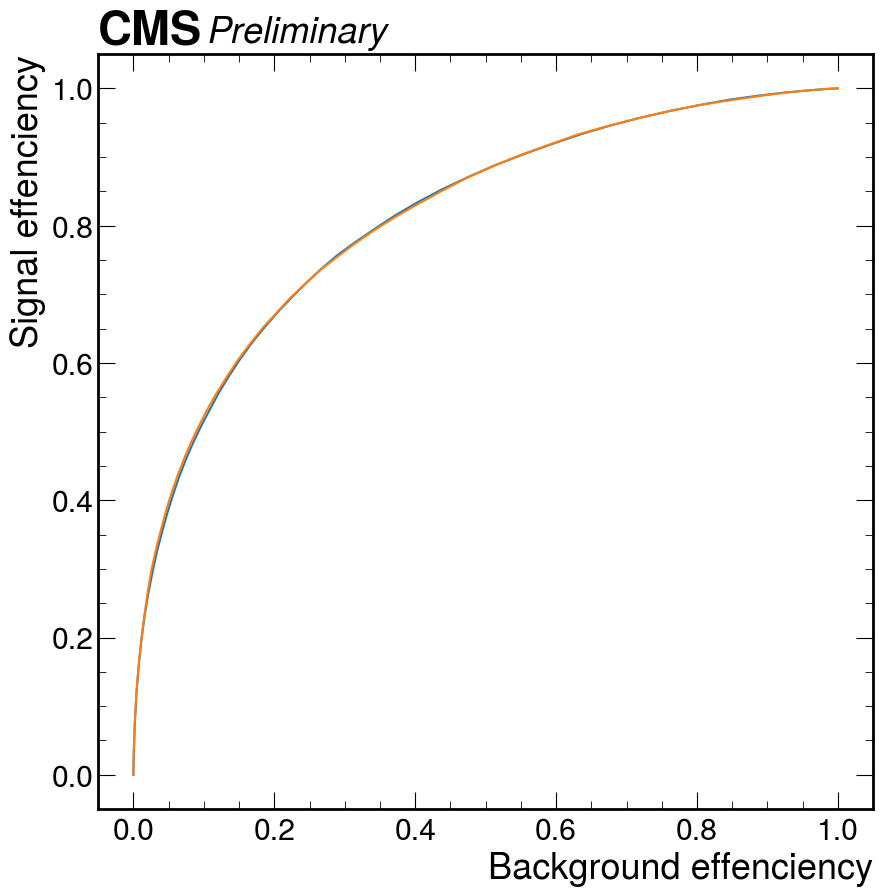

In [158]:
from sklearn.metrics import auc
plt.plot(b_tr,s_tr, label='ROC train')
plt.plot(b_test,s_test,  label='ROC test')
plt.xlabel("Background effenciency")
plt.ylabel("Signal effenciency")
hep.cms.text("Preliminary")
print(auc(b_tr,s_tr))

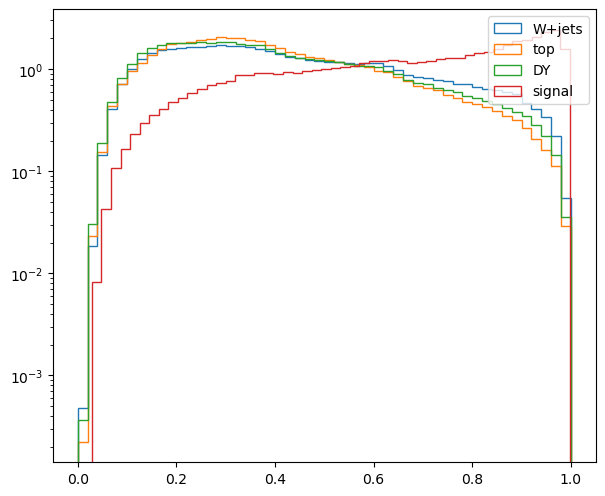

In [35]:
fig, ax1 = plt.subplots(figsize=(7,6), dpi=100)
plt.hist(bkg[bkg["sample_name"] == "Wjets_HT"]["y"], bins=50,range=(0,1), density=True, label="W+jets", histtype="step" )
plt.hist(bkg[bkg["sample_name"] == "top"]["y"],   bins=50,range=(0,1), density=True, label="top",    histtype="step")
plt.hist(bkg[bkg["sample_name"] == "DY"]["y"],    bins=50,range=(0,1), density=True, label="DY",     histtype="step")

plt.hist(signal["y"], bins=50,density=True, label="signal", histtype="step")
plt.yscale("log")
plt.legend()

With weights

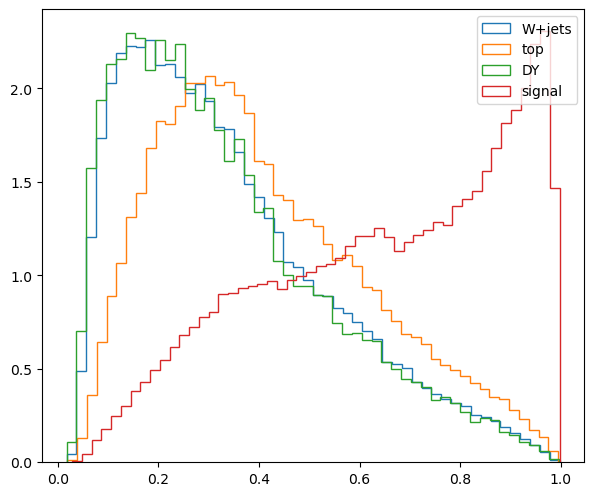

In [37]:
fig, ax1 = plt.subplots(figsize=(7,6), dpi=100)
plt.hist(wjets["y"], weights=wjets.weight_norm, bins=50, density=True, label="W+jets", histtype="step")
plt.hist(top["y"],   weights=top.weight_norm,  bins=50, density=True, label="top",    histtype="step")
plt.hist(dy["y"],    weights=dy.weight_norm,  bins=50, density=True, label="DY",     histtype="step")

plt.hist(signal["y"], weights=signal.weight_norm, bins=50,density=True, label="signal", histtype="step")
#plt.yscale("log")
plt.legend()

## Cumulative distribution for signal

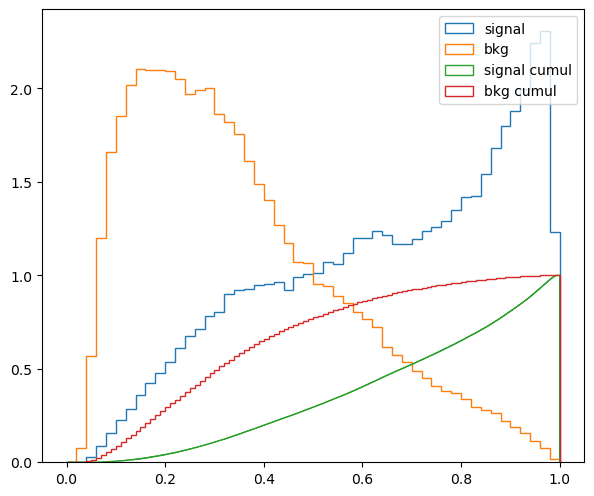

In [38]:
fig, ax1 = plt.subplots(figsize=(7,6), dpi=100)

plt.hist(signal["y"], weights=signal.weight, bins=50,density=True, label="signal", histtype="step",range=(0,1))
plt.hist(bkg["y"], weights=bkg.weight, bins=50,density=True, label="bkg", histtype="step",range=(0,1))
hcumul = plt.hist(signal["y"], weights=signal.weight, bins=1000,cumulative=True, density=True, range=(0,1),label="signal cumul", histtype="step")
hcumul_bkg = plt.hist(bkg["y"], weights=bkg.weight, bins=100,cumulative=True, density=True, range=(0,1),label="bkg cumul", histtype="step")
plt.legend()

In [32]:
hcumul

(array([3.18615208e-04, 5.99026264e-04, 7.27979919e-04, 7.75514305e-04,
        8.51087394e-04, 1.00259926e-03, 1.07923476e-03, 1.26383687e-03,
        1.28346434e-03, 1.37957374e-03, 1.38581263e-03, 1.41036636e-03,
        1.47712840e-03, 1.53041008e-03, 1.53916217e-03, 1.60469182e-03,
        1.69782736e-03, 1.69782736e-03, 1.72411599e-03, 1.75863318e-03,
        1.80339220e-03, 1.86526983e-03, 1.89685385e-03, 1.95248021e-03,
        1.95248021e-03, 2.04768045e-03, 2.13784172e-03, 2.21085612e-03,
        2.36078300e-03, 2.37556069e-03, 2.38868616e-03, 2.42151003e-03,
        2.47752810e-03, 2.48690567e-03, 2.50588535e-03, 2.54648345e-03,
        2.55563825e-03, 2.67070516e-03, 2.70274033e-03, 2.72629783e-03,
        2.79722013e-03, 2.83265602e-03, 2.87969987e-03, 2.89682448e-03,
        2.97580601e-03, 3.01330623e-03, 3.07866355e-03, 3.10852192e-03,
        3.18328892e-03, 3.20852774e-03, 3.27760145e-03, 3.30998143e-03,
        3.37923947e-03, 3.49344286e-03, 3.53493865e-03, 3.569290

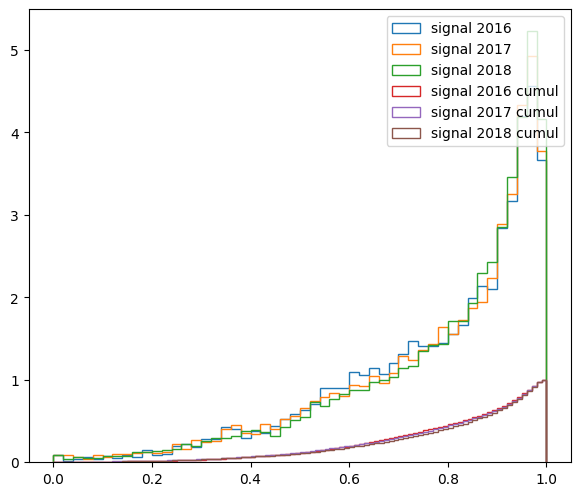

In [35]:
fig, ax1 = plt.subplots(figsize=(7,6), dpi=100)

plt.hist(signal[signal.year==2016]["y"], weights=signal[signal.year==2016].weight, bins=50,density=True, label="signal 2016", histtype="step",range=(0,1))
plt.hist(signal[signal.year==2017]["y"], weights=signal[signal.year==2017].weight, bins=50,density=True, label="signal 2017", histtype="step",range=(0,1))
plt.hist(signal[signal.year==2018]["y"], weights=signal[signal.year==2018].weight, bins=50,density=True, label="signal 2018", histtype="step",range=(0,1))

hcumul = plt.hist(signal[signal.year==2016]["y"], weights=signal[signal.year==2016].weight, bins=100,cumulative=True, density=True, range=(0,1),label="signal 2016 cumul", histtype="step")
hcumul = plt.hist(signal[signal.year==2017]["y"], weights=signal[signal.year==2017].weight, bins=100,cumulative=True, density=True, range=(0,1),label="signal 2017 cumul", histtype="step")
hcumul = plt.hist(signal[signal.year==2018]["y"], weights=signal[signal.year==2018].weight, bins=100,cumulative=True, density=True, range=(0,1),label="signal 2018 cumul", histtype="step")
plt.legend()

In [36]:
import ROOT as R
gr = R.TGraph()
for i in range(1000):
    #print(i, (hcumul[1][i+1] + hcumul[1][i])/2, hcumul[0][i])
    gr.SetPoint(i, (hcumul[1][i+1] + hcumul[1][i])/2, hcumul[0][i])
gr.SetPoint(1000, 1., 1.)
c= R.TCanvas()
gr.Draw("APL")
c.Draw()


ModuleNotFoundError: No module named 'ROOT'

In [21]:
outputfile = R.TFile("cumulative_signal_boost_v5.root", "recreate")
gr.SetName("cumulative_signal")
gr.Write()
outputfile.Close()

In [22]:
gr.SetBit(R.TGraph.kIsSortedX)

signal["y_scaled"] = signal.y.map(gr.Eval)
bkg["y_scaled"] = bkg.y.map(gr.Eval)
wjets["y_scaled"] = wjets.y.map(gr.Eval)


/usr/local/bin/start_ipykernel.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [29]:
gr.Eval(0.972116)

0.9956812447588439

In [76]:
signal[signal.y_scaled> 0.98]

,events,Lepton_eta_abs,Lepton_eta,Lepton_pt,deltaeta_vbs,deta_jetpt_CR,PuppiMET,mjj_vbs_morebins,vbs_0_pt,vbs_1_pt,...,Centr_ww,nvtx,weight_,sample_name,class,signal,year,weight_norm,y,y_scaled
147873,1,0.480652,0.480652,78.274681,5.943848,8,112.215309,4520.237305,251.25,212.125,...,1.997558,21,0.000145,VBS,0,1,2018,8.933451,0.981988,0.980068


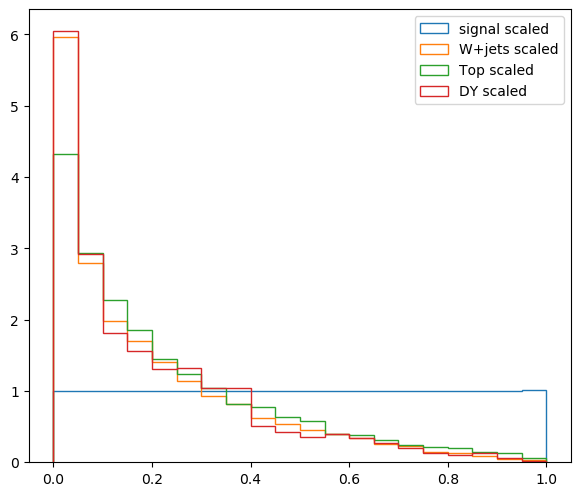

In [23]:
fig, ax1 = plt.subplots(figsize=(7,6), dpi=100)

nbins = 20 
plt.hist(signal["y_scaled"], weights=signal.weight_, bins=nbins,density=True, label="signal scaled", histtype="step",range=(0,1))
plt.hist(bkg[bkg.sample_name =="Wjets"]["y_scaled"], weights=bkg[bkg.sample_name =="Wjets"].weight_,
             bins=nbins,density=True, label="W+jets scaled", histtype="step",range=(0,1))
plt.hist(bkg[bkg.sample_name =="top"]["y_scaled"], weights=bkg[bkg.sample_name =="top"].weight_,
             bins=nbins,density=True, label="Top scaled", histtype="step",range=(0,1))
plt.hist(bkg[bkg.sample_name =="DY"]["y_scaled"], weights=bkg[bkg.sample_name =="DY"].weight_,
             bins=nbins,density=True, label="DY scaled", histtype="step",range=(0,1))
plt.legend()

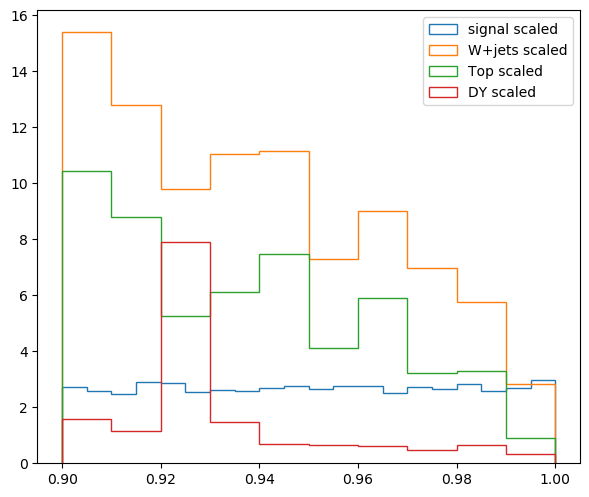

In [24]:
fig, ax1 = plt.subplots(figsize=(7,6), dpi=100)

plt.hist(signal["y_scaled"], weights=signal.weight_*130, bins=20, label="signal scaled", histtype="step",range=(0.9,1))
plt.hist(bkg[bkg.sample_name =="Wjets"]["y_scaled"], weights=bkg[bkg.sample_name =="Wjets"].weight_*130,
             bins=10, label="W+jets scaled", histtype="step",range=(0.9,1))
plt.hist(bkg[bkg.sample_name =="top"]["y_scaled"], weights=bkg[bkg.sample_name =="top"].weight_*130,
             bins=10,label="Top scaled", histtype="step",range=(0.9,1))
plt.hist(bkg[bkg.sample_name =="DY"]["y_scaled"], weights=bkg[bkg.sample_name =="DY"].weight_*130,
             bins=10, label="DY scaled", histtype="step",range=(0.9,1))
plt.legend()